# CoSen: Cost Sensitive CNN loss

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, ConcatDataset
import torchmetrics

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

from costsensitive.losses import CostSensitiveLoss, CostSensitiveRegularizedLoss

Basic usage:

```
                Predicted
              
Ground truth        M
```

In [33]:
n_classes = 3
criterion = CostSensitiveLoss(n_classes)

M = np.array([[0,0,0], [0,0,0], [10, 0, 0]], dtype=float)
M /= M.max()
criterion.M = torch.from_numpy(M)

label = torch.tensor([2]).unsqueeze(0)
logits_bad = torch.tensor([10., 0., 0.]).unsqueeze(0)
print('Bad logits:', criterion(logits_bad, label))
logits_ok = torch.Tensor([0., 0., 10.]).unsqueeze(0)
print('Good logits:', criterion(logits_ok, label))

Bad logits: tensor(0.9999, dtype=torch.float64)
Good logits: tensor(4.5396e-05, dtype=torch.float64)


Mixed as a regularizer Cross Entropy Loss Function:

In [3]:
n_classes = 3 
base_loss = 'ce' #can be ce (x-entropy), ls (label smoothing), gls (gaussian label smoothing)
lambd = 10
cs_regularized_criterion = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)
labels = torch.tensor([2])
worse_logits = torch.tensor([10.0, 0.0, 0.0]).unsqueeze(0)
better_logits = torch.tensor([0.0, 10.0, 0.0]).unsqueeze(0)
perfect_logits = torch.tensor([0.0, 0.0, 10.0]).unsqueeze(0)
print('Cost Sensitive-Regularized CE loss:')
print('Worst prediction loss = {:.4f}'.format(cs_regularized_criterion(worse_logits, labels)))
print('Better prediction loss = {:.4f}'.format(cs_regularized_criterion(better_logits, labels)))
print('Perfect prediction loss = {:.4f}'.format(cs_regularized_criterion(perfect_logits, labels)))

Cost Sensitive-Regularized CE loss:
Worst prediction loss = 19.9993
Better prediction loss = 12.5003
Perfect prediction loss = 0.0007


Comparison CE-Cost-sensitive vs. standard Cross Entropy Loss:

In [20]:
ce = nn.CrossEntropyLoss()
cost = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss='ce', lambd=lambd)
print('Cost Sensitive-Regularized CE loss with Gaussian Label Smoothing:')
print(f'Worst prediction loss     Cost: {cost(worse_logits, labels):.4f}      CE: {ce(worse_logits, labels):.4f}')
print(f'Better prediction loss    Cost: {cost(better_logits, labels):.4f}      CE: {ce(better_logits, labels):.4f}')
print(f'Perfect prediction loss   Cost: {cost(perfect_logits, labels):.4f}       CE: {ce(perfect_logits, labels):.4f}')

Cost Sensitive-Regularized CE loss with Gaussian Label Smoothing:
Worst prediction loss     Cost: 11.0000      CE: 10.0001
Better prediction loss    Cost: 10.2501      CE: 10.0001
Perfect prediction loss   Cost: 0.0001       CE: 0.0001


Main code:

In [2]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=[-10,10]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/PlantVillage/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
# class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])
print('Total:', len(image_dataset))

Class 0: 1591 / Class 1: 373 / BDeg:  4.265415549597855
Total: 1964


In [3]:
cm = CostSensitiveRegularizedLoss(n_classes=2, base_loss='ce', lambd=10)
# ASSUME that class 1 is the small here
M = np.array([[0,1/b_deg],
              [b_deg ,0]], dtype=float)
cm.M = torch.from_numpy(M / M.max())
print(cm.M)

zero_logits = torch.tensor([10.0, 0.0]).unsqueeze(0)
one_logits = torch.tensor([0.0, 10.0]).unsqueeze(0)
# So if it's class 1 but we predict 0 -> BIG COST (dependent on balance degree!!)
print(f'predict 0 (big) when 1 (small) = {cm(zero_logits, torch.tensor([1])):.4f}')
# and if it's 0 but we predict 1 -> smaller cost
print(f'predict 1 (small) when 0 (big) = {cm(one_logits, torch.tensor([0])):.4f}')
# (and 0 cost if predicted well)
print(f'predict 1 when 1 = {cm(one_logits, torch.tensor([1])):.4f}')
print(f'predict 0 when 0 = {cm(zero_logits, torch.tensor([0])):.4f}')

tensor([[0.0000, 0.0550],
        [1.0000, 0.0000]], dtype=torch.float64)
predict 0 (big) when 1 (small) = 19.9996
predict 1 (small) when 0 (big) = 10.5497
predict 1 when 1 = 0.0005
predict 0 when 0 = 0.0001


In [10]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self, config, class_sizes=[1,1]):
        super().__init__()
        self.n_classes = len(class_sizes)
        c0_s, c1_s = class_sizes
        b_deg = c0_s / c1_s # ASSUME that class 1 is the small one here!!!
        
        self.lr = config['lr']
        self.EPOCHS = config['epochs']
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        # Cost-Sensitive loss
        self.loss = CostSensitiveRegularizedLoss(n_classes=2, base_loss='ce', lambd=10)
        M = np.array([[0,1/b_deg],
                      [b_deg ,0]], dtype=float)
        cm.M = torch.from_numpy(M / M.max())
        self.loss = self.loss.cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss = self.loss(logits, y)
        mean_losses.append(mean_loss)

        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=self.SPE,
                                epochs=self.EPOCHS)
        }

In [15]:
K=5
BATCH_SIZE=10
EPOCHS=1
GAMMA_0=2

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

def train_tune(config):
    kfold = KFold(n_splits=K, shuffle=True)
    reports = []
    mean_f1s = []
    for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
        print(f'------------fold nº {fold}----------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        trainloader = torch.utils.data.DataLoader(
                          image_dataset, 
                          batch_size=BATCH_SIZE, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                          image_dataset,
                          batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Train this fold
        model = ResNetCustom(config, class_sizes=[c0_s,c1_s])
        model.SPE = len(trainloader)
        trainer = pl.Trainer(max_epochs=config['epochs'], devices=1, accelerator="gpu")
        trainer.fit(model, trainloader)

        # Test this fold
        true_y, pred_y = [], []
        for batch in tqdm(iter(testloader), total=len(testloader)):
            x, y = batch
            true_y.extend(y)
            preds, probs = get_prediction(x, model)
            pred_y.extend(preds.cpu())

        report = classification_report(true_y, pred_y, output_dict=True)
        reports.append(report)
        mean_f1s.append((report['0']['f1-score']+report['1']['f1-score'])/2)
#         print('=> CONFIG:', config)
#         print(classification_report(true_y, pred_y))
    max_f1_idx = mean_f1s.index(max(mean_f1s))
    return reports[max_f1_idx]

EPOCHS = [20]
LRS = [1e-4]

grid_search = pd.DataFrame(columns=['epochs','lr','f1-0','f1-1','acc'])

for epochs in EPOCHS:
    for lr in LRS:
        config = {'epochs': epochs, 'lr': lr}
        report = train_tune(config)
        grid_search = grid_search.append(
                        pd.Series(
                            [epochs,lr,report['0']['f1-score'],report['1']['f1-score'],report['accuracy']],
                            index=grid_search.columns), 
                        ignore_index=True)
        grid_search.to_csv('./grid_search/plant_village_cosen.csv')
grid_search

------------fold nº 0----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | accuracy | BinaryAccuracy               | 0     
1 | f1score  | BinaryF1Score                | 0     
2 | model    | ResNet                       | 23.5 M
3 | loss     | CostSensitiveRegularizedLoss | 0     
----------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 1

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

------------fold nº 1----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | accuracy | BinaryAccuracy               | 0     
1 | f1score  | BinaryF1Score                | 0     
2 | model    | ResNet                       | 23.5 M
3 | loss     | CostSensitiveRegularizedLoss | 0     
----------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 1

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

------------fold nº 2----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | accuracy | BinaryAccuracy               | 0     
1 | f1score  | BinaryF1Score                | 0     
2 | model    | ResNet                       | 23.5 M
3 | loss     | CostSensitiveRegularizedLoss | 0     
----------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 1

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

------------fold nº 3----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | accuracy | BinaryAccuracy               | 0     
1 | f1score  | BinaryF1Score                | 0     
2 | model    | ResNet                       | 23.5 M
3 | loss     | CostSensitiveRegularizedLoss | 0     
----------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 1

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

------------fold nº 4----------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | accuracy | BinaryAccuracy               | 0     
1 | f1score  | BinaryF1Score                | 0     
2 | model    | ResNet                       | 23.5 M
3 | loss     | CostSensitiveRegularizedLoss | 0     
----------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 1

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

,epochs,lr,f1-0,f1-1,acc
0,20.0,0.0001,1.0,1.0,1.0


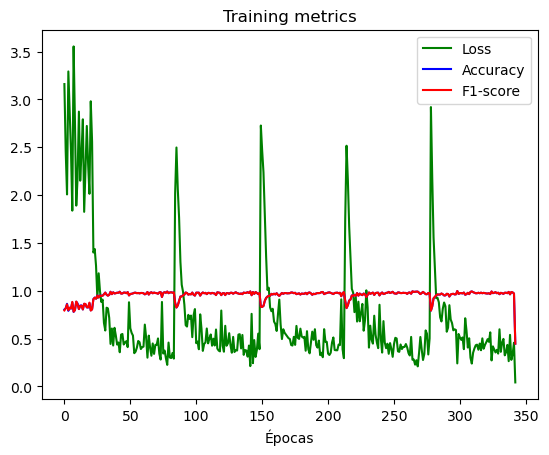

In [18]:
# Plot mean loss
x_axis = [i for i in range(343)]

splits=49
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
# plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='Accuracy')
plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()